In [1]:
import os
import sys
import json
import numpy as np
from tqdm import tqdm
from torch import optim
from kornia.morphology import dilation
from torch.nn import DataParallel
from torch.nn.functional import binary_cross_entropy, one_hot, binary_cross_entropy_with_logits
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from loss_functions import FocalLoss
from test_model_performance import *

import matplotlib.pyplot as plt
from unet import *
from data_loading import *

In [2]:
BATCH_SIZE=100
DATA_PATH = '/media/anthony/Storage_1/aviation_data/dataset-test'
# DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
DEVICE='cpu'

In [3]:
# Load in the 2020 test data
test_loader, X, y = load_data(DATA_PATH, BATCH_SIZE)

In [ ]:
# Plot the U, V, Gust components of Wind
fig, ax = plt.subplots(1, 3, figsize=(24, 12), sharex=True)
ax[0].imshow(X[3, 4,:, :], cmap='Greys')
ax[0].set_title('U-Wind Component')
ax[1].imshow(X[3, 5,:, :], cmap='Greys')
ax[1].set_title('V-Wind Component')
ax[2].imshow(X[3, 6,:, :], cmap='Greys')
ax[2].set_title('24 Hour Mean Wind Gust')
plt.show()

In [3]:
# Get the number of days and fires in the full dataset
days = 0
fires = []
for fname in os.listdir('/media/anthony/Storage_1/aviation_data/dataset-big'):
    if fname.split('.')[1] != 'tif':
        continue
    id = fname.split('-')[1]
    fires.append(id)
    days += 1
fires = len(set(fires))

print(f'days: {days}, fires: {fires}')

FileNotFoundError: [Errno 2] No such file or directory: '/media/anthony/Storage_1/aviation_data/dataset-big'

# ATTEMPT 1

## Without Label Weights

In [ ]:
model = init_model('results/attempt-3/model.nn')
model.to(DEVICE)
model.eval()
with open('results/attempt-3/results.json') as fin:
    train_results = json.load(fin)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(24, 12), sharex=True)
ax[0, 0].plot(train_results['val_correct_0'], lw=4)
ax[0, 0].set_title('Ratio of correct Label 0 classifications')
ax[0, 1].plot(train_results['val_correct_1'], lw=4)
ax[0, 1].set_title('Ratio of correct Label 1 classifications')
ax[1, 0].plot(train_results['val_guess_0'], lw=4)
ax[1, 0].set_title('Ratio of total Label 0 classifications')
ax[1, 1].plot(train_results['val_guess_1'], lw=4)
ax[1, 1].set_title('Ratio of total Label 1 classifications')
plt.subplots_adjust(wspace=0.075, hspace=0.1)
plt.show()

In [ ]:
results = test_model(test_loader, model, DEVICE)
ratio_guess_none, ratio_guess_new, ratio_correct_none, ratio_correct_new, ratio_correct_total = results
print('\n***********************************************************')
print(f'TEST ACCURACIES: 0: {ratio_correct_none*100:.2f}%, 1: {ratio_correct_new*100:.2f}%')
print(f'TEST OVERFITTING: 0: {ratio_guess_none:.2f}, 1: {ratio_guess_new:.2f}')
print(f'TOTAL TEST ACCURACY {ratio_correct_total*100:.4f}%')
print('***********************************************************')

In [ ]:
input, label, prediction = run_random_raster(test_loader, model, DEVICE)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))
ax[0].imshow(input[0][:][:], cmap='YlOrRd')
ax[1].imshow(label[0][:][:], cmap='YlOrRd')
ax[2].imshow(prediction[0, :, :], cmap='YlOrRd')
ax[0].set_title('Previous Day\'s Fire')
ax[1].set_title('Actual Fire Growth')
ax[2].set_title('Predicted Fire Growth')
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# ATTEMPT 2
## With Label Weights

In [ ]:
model = init_model('results/attempt-1/model.nn')
model.to(DEVICE)
model.eval()
with open('results/attempt-1/results.json') as fin:
    train_results = json.load(fin)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(24, 12), sharex=True)
ax[0, 0].plot(train_results['val_correct_0'], lw=4)
ax[0, 0].set_title('Ratio of CORRECT Label 0 classifications')
ax[0, 1].plot(train_results['val_correct_1'], lw=4)
ax[0, 1].set_title('Ratio of CORRECT Label 1 classifications')
ax[1, 0].plot(train_results['val_guess_0'], lw=4)
ax[1, 0].set_title('Ratio of TOTAL Label 0 classifications')
ax[1, 1].plot(train_results['val_guess_1'], lw=4)
ax[1, 1].set_title('Ratio of TOTAL Label 1 classifications')
plt.subplots_adjust(wspace=0.075, hspace=0.1)
plt.show()

In [ ]:
results = test_model(test_loader, model, DEVICE)
ratio_guess_none, ratio_guess_new, ratio_correct_none, ratio_correct_new, ratio_correct_total = results
print('\n***********************************************************')
print(f'TEST ACCURACIES: 0: {ratio_correct_none*100:.2f}%, 1: {ratio_correct_new*100:.2f}%')
print(f'TEST OVERFITTING: 0: {ratio_guess_none:.2f}, 1: {ratio_guess_new:.2f}')
print(f'TOTAL TEST ACCURACY {ratio_correct_total*100:.4f}%')
print('***********************************************************')

In [ ]:
input, label, prediction = run_random_raster(test_loader, model, DEVICE)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))
ax[0].imshow(input[0][:][:], cmap='YlOrRd')
ax[1].imshow(label[0][:][:], cmap='YlOrRd')
ax[2].imshow(prediction[0, :, :], cmap='YlOrRd')
ax[0].set_title('Previous Day\'s Fire')
ax[1].set_title('Actual Fire Growth')
ax[2].set_title('Predicted Fire Growth')
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# ATTEMPT 3
## Label Weight Mask

In [4]:
model = init_model('results/attempt-4/model.nn')
model.to(DEVICE)
model.eval()
with open('results/attempt-4/results.json') as fin:
    train_results = json.load(fin)


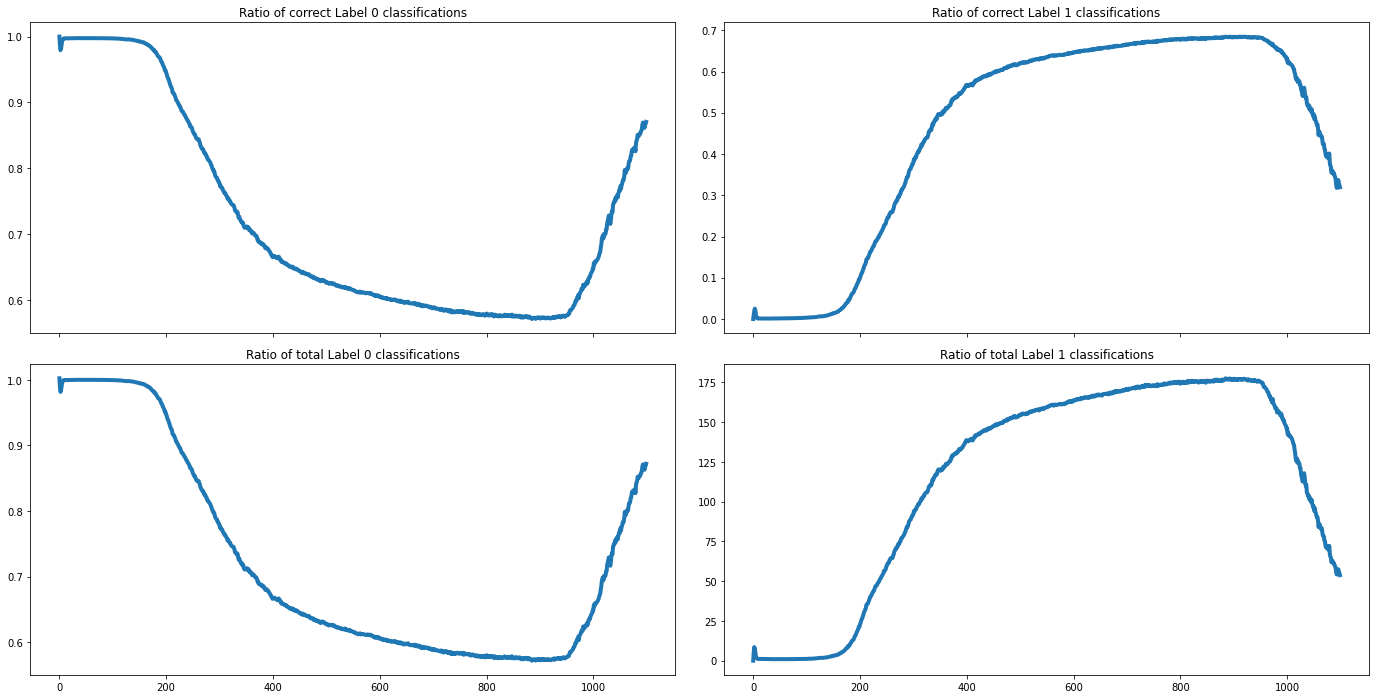

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(24, 12), sharex=True)
ax[0, 0].plot(train_results['val_correct_0'], lw=4)
ax[0, 0].set_title('Ratio of correct Label 0 classifications')
ax[0, 1].plot(train_results['val_correct_1'], lw=4)
ax[0, 1].set_title('Ratio of correct Label 1 classifications')
ax[1, 0].plot(train_results['val_guess_0'], lw=4)
ax[1, 0].set_title('Ratio of total Label 0 classifications')
ax[1, 1].plot(train_results['val_guess_1'], lw=4)
ax[1, 1].set_title('Ratio of total Label 1 classifications')
plt.subplots_adjust(wspace=0.075, hspace=0.1)
plt.show()

In [6]:
results = test_model(test_loader, model, DEVICE)
ratio_guess_none, ratio_guess_new, ratio_correct_none, ratio_correct_new, ratio_correct_total = results
print('\n***********************************************************')
print(f'TEST ACCURACIES: 0: {ratio_correct_none*100:.2f}%, 1: {ratio_correct_new*100:.2f}%')
print(f'TEST OVERFITTING: 0: {ratio_guess_none:.2f}, 1: {ratio_guess_new:.2f}')
print(f'TOTAL TEST ACCURACY {ratio_correct_total*100:.4f}%')
print('***********************************************************')


***********************************************************
TEST ACCURACIES: 0: 0.01%, 1: 100.00%
TEST OVERFITTING: 0: 0.00, 1: 324.41
TOTAL TEST ACCURACY 0.3138%
***********************************************************


In [47]:
input, label, prediction = run_random_raster(test_loader, model, DEVICE)

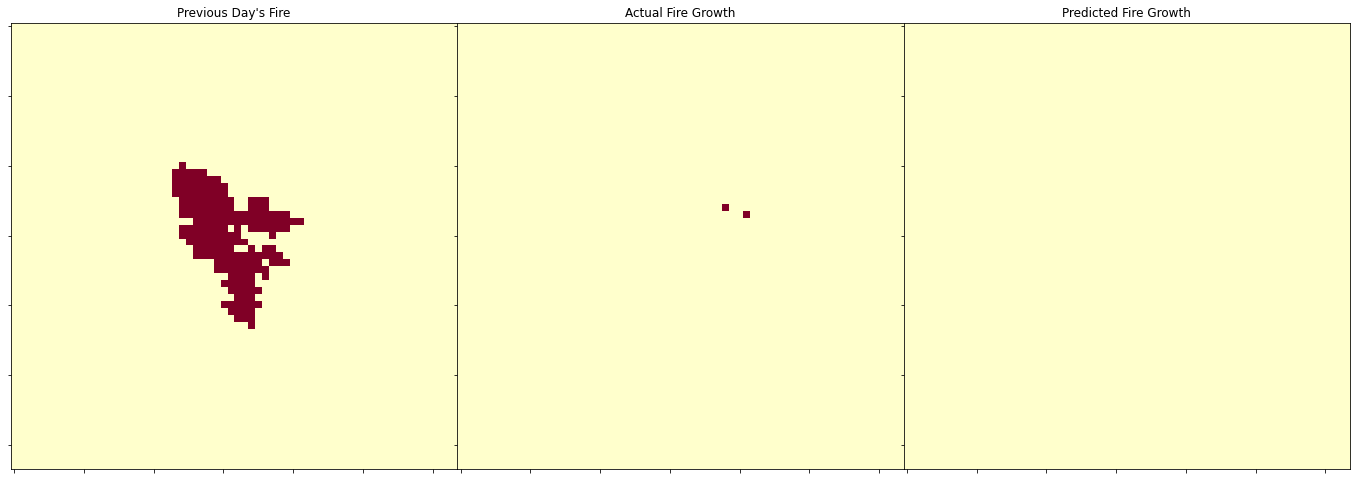

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))
ax[0].imshow(input[0][:][:], cmap='YlOrRd')
ax[1].imshow(label[0][:][:], cmap='YlOrRd')
ax[2].imshow(prediction[0, :, :], cmap='YlOrRd')
ax[0].set_title('Previous Day\'s Fire')
ax[1].set_title('Actual Fire Growth')
ax[2].set_title('Predicted Fire Growth')
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()